In [ ]:
pip install easyocr
pip install imutils

Result []

Number plate detected:  


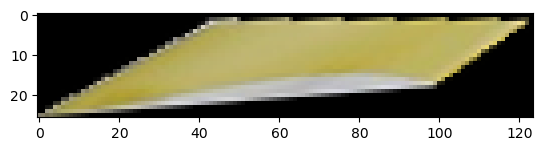

In [21]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr
# 1. Read in Image, Grayscale and Blur
img = cv2.imread('lpr_dataset/images/N19.jpeg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

# 2. Apply filter and find edges for localization
img.shape
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction
edged = cv2.Canny(bfilter, 30, 200) #Edge detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

# 3. Find Contours and Apply Mask
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) ==4:
        location = approx
        break

new_loc = list(list(i) for j in range(4) for i in location[j])
new_loc
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0,255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)
mask.shape

plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]

plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

def correct_tilt(image, coordinates):
    # Convert the coordinates to a numpy array
    coordinates = np.array(coordinates)

    # Calculate the angle of tilt based on the coordinates
    angle = 0
    if len(coordinates) == 4:
        # Calculate the angle of the longest side of the bounding box formed by the coordinates
        x1, y1 = coordinates[0][0], coordinates[0][1]
        x2, y2 = coordinates[1][0], coordinates[1][1]
        x3, y3 = coordinates[2][0], coordinates[2][1]
        x4, y4 = coordinates[3][0], coordinates[3][1]

        # Calculate the lengths of the sides of the quadrilateral
        d1 = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
        d2 = np.sqrt((x2 - x3)**2 + (y2 - y3)**2)

#         print(d1, d2)
        # Calculate the angle of the longest side with respect to the horizontal axis
        angle = np.arctan2(abs(y2 - y1), abs(x2 - x1)) * 180 / np.pi
        if d2 > d1:
            angle = np.arctan2(abs(y3 - y2), abs(x3 - x2)) * 180 / np.pi

    # Rotate the image to correct the tilt
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    return rotated_image

# Load the image
# image = cv2.imread('original_image.jpg')

# Coordinates of the object in the image
coordinates = tuple(new_loc)  # Example coordinates (adjust based on your data)

# Correct the tilt for the object at the specified coordinates
corrected_image = correct_tilt(new_image, coordinates)

# Display the original and corrected images
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
# plt.imshow('Original Image', new_image)
# plt.imshow('Corrected Image', corrected_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

plt.imshow(cv2.cvtColor(corrected_image, cv2.COLOR_BGR2RGB))

import cv2
import easyocr

def remove_background(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply thresholding
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get the largest contour
    contour = max(contours, key=cv2.contourArea)

    # Create a mask for the contour
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)

    # Apply the mask to the image to remove the background
    result = cv2.bitwise_and(image, image, mask=mask)

    return result

def crop_object(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Find contours
    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get the bounding box of the largest contour
    x, y, w, h = cv2.boundingRect(contours[0])

    # Crop the object from the image
    cropped_image = image[y:y+h, x:x+w]

    return cropped_image

# Load the image
# image = cv2.imread('image_with_object.jpg')

# Remove black background
removed_background = remove_background(corrected_image)

# Crop the object
cropped_object = crop_object(removed_background)

# Initialize EasyOCR reader
reader = easyocr.Reader(['en'])

# Apply EasyOCR to extract text
result = reader.readtext(cropped_object)

# Print the extracted text
fs = ''
for detection in result:
    if len(detection)>1:
        fs = fs + str(detection[1])
# if fs:
#     print(fs)
# else:
#     print(detection[1])

# Display the cropped object
# cv2.imshow('Cropped Object', cropped_object)
plt.imshow(cv2.cvtColor(cropped_object, cv2.COLOR_BGR2RGB))


def remove_black_background(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold the grayscale image to get a binary mask of the non-black regions
    _, mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

    # Find contours in the binary mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get the bounding box of the non-black regions
    x, y, w, h = cv2.boundingRect(contours[0])

    # Crop the image based on the bounding box
    cropped_image = image[y:y+h, x:x+w]

    return cropped_image

# Load the image with black background
# image = cv2.imread('image_with_black_background.jpg')

# Remove black background and crop the image
cropped_image = remove_black_background(corrected_image)

# Display the original and cropped images
# cv2.imshow('Original Image', corrected_image)
# cv2.imshow('Cropped Image', cropped_image)

# plt.imshow(cv2.cvtColor(corrected_image, cv2.COLOR_BGR2RGB))
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

# 4. Use Easy OCR To Read Text
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
        
print("Result", result)

print("\nNumber plate detected: ", fs)
